In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from fastai.basics import L, DataLoaders, Learner
# from fastai.tabular.all import *
import numpy as np
import mne
import zarr
import seaborn as sns
import matplotlib.pyplot as plt
%cd fastAI/GitHub/
from model20 import stagerNetAAE
from utils1 import LossAttrMetric, GetLatentSpace, norm_batch, UnfreezeFcCrit, \
                SwitchAttribute, distrib_regul_regression, hist_lab, plot_results

device = torch.device('cuda:1')
torch.cuda.set_device(device)
print('the current device is: ', device)

# Define the channels to display
chan_select = slice(0,17,2)

# Get channel names
file_path = '/home/JennebauffeC/pytorchVAE/fastAI/Monitosed/Biowin/sub-001/VR_1_VRH.vhdr'
monitosed_VR1 = mne.io.read_raw_brainvision(file_path, preload=True)
montage = monitosed_VR1.get_montage()

electrode_info = montage.get_positions()['ch_pos']
chan_names = list(electrode_info.keys())
sliced_chan = chan_names[chan_select]
print('selected channels: ', sliced_chan)

# Define frequency bands
frequency_bands = {
    'alpha': (8, 13),
    'beta': (13, 24),
    'delta': (0.5, 4),
    'theta': (4, 8)
}

[Errno 2] No such file or directory: 'fastAI/GitHub/'
/home/JennebauffeC/pytorchVAE/fastAI/GitHub
the current device is:  cuda:1
Extracting parameters from /home/JennebauffeC/pytorchVAE/fastAI/Monitosed/Biowin/sub-001/VR_1_VRH.vhdr...
Setting channel info structure...
Reading 0 ... 924099  =      0.000 ...   924.099 secs...
['Fp1', 'F3', 'F9', 'FC1', 'T7', 'CP1', 'P3', 'P9', 'Oz']


In [ ]:
# Sliding window function
def sliding_window(data, window_size, step_size):
    print('in sliding windows, data shape: ', data.shape)
    num_windows = (data.shape[-1] - window_size) // step_size + 1
    windows = [data[:,:,i * step_size: i * step_size + window_size] for i in range(num_windows)]
    return torch.stack(windows)

# Compute power spectrum within each window
def compute_power_spectrum(data, nfft=64):
    print('data shape: ', data.shape)
    return torch.fft.fft(data.to('cpu'), n=nfft, dim=-1).abs().to(device) ** 2

# Compute band power within each window
def compute_band_power(power_spectrum, frequency_bands, sampling_rate=50):
    band_power = {}
    for band_name, (low_freq, high_freq) in frequency_bands.items():
        freq_indices = torch.where(
            (torch.fft.fftfreq(power_spectrum.shape[-1], d=1 / sampling_rate) >= low_freq) &
            (torch.fft.fftfreq(power_spectrum.shape[-1], d=1 / sampling_rate) <= high_freq)
        )[0]
        band_power[band_name] = power_spectrum[:, :, freq_indices].mean(dim=2)
    return band_power

# Sliding window analysis and statistical computation
def analyze_power_evolution(t, sorted_idx, window_size, step_size):
    sliding_windows = sliding_window(t[sorted_idx], window_size, step_size)
    power_spectra = compute_power_spectrum(sliding_windows)

    band_power_over_time = {band: [] for band in frequency_bands}
    for power_spectrum in power_spectra:
        band_power = compute_band_power(power_spectrum, frequency_bands)
        for band in frequency_bands:
            band_power_over_time[band].append(band_power[band].mean(dim=0))

    for band in frequency_bands:
        band_power_over_time[band] = torch.stack(band_power_over_time[band])

    return band_power_over_time

# Normalize EEG data
def normalize_eeg_data(x):
    eps = 1e-08
    mean = torch.nanmean(x, dim=2)
    std = torch.clamp_min(torch.std(x, dim=2), eps)
    x_norm = (x - mean.unsqueeze(-1)) / torch.clamp_min(std.unsqueeze(-1), eps)
    return torch.clamp(torch.clamp(x_norm, min=-3), max=3).float()

# Plot band power over time
def plot_band_power_over_time(band_power_over_time, frequency_bands, channel_names, window_size, step_size):
    num_windows = len(band_power_over_time[list(frequency_bands.keys())[0]])
    time_axis = torch.arange(0, num_windows * step_size, step_size) + window_size // 2

    for band, powers in band_power_over_time.items():
        plt.figure(figsize=(12, 6))
        sns.heatmap(powers.T.cpu().numpy(), xticklabels=time_axis.cpu().numpy(), yticklabels=channel_names, cmap='viridis')
        plt.title(f'Power Evolution in {band.capitalize()} Band')
        plt.xlabel('Time (samples)')
        plt.ylabel('Channels')
        plt.show()

In [ ]:
# Load required data
target_pair = 'REST0_VRH2'
classif_filename = 'monitosed_BIOWIN_aae_classif_REST_VRH_05_24_17h_latent64'
# classif_filename = 'monitosed_BIOWIN_aae_classif_REST_HYP_03_26_19h'
# classif_filename = 'monitosed_BIOWIN_aae_classif_HYP_VRH_03_26_19h'
state_dict = torch.load(f'models/{classif_filename}.pth') # load the best weights

data_dir = f'/databases/monitosed-LUCA/Preprocessed_Data/{target_pair}'
zarr_dir = f'/home/JennebauffeC/pytorchVAE/fastAI/Monitosed/preprocessed_data/{target_pair}'

x_zarr = zarr.load(f'{data_dir}/x.zarr')
ica_zarr = zarr.open(f'{zarr_dir}/ica.zarr', mode='r')
x = torch.tensor(ica_zarr, device=device).float()
x_norm = normalize_eeg_data(x)
t = normalize_eeg_data(torch.tensor(x_zarr, device=device).float())

y = torch.load(f'{data_dir}/y.pt')
y_tensor = torch.tensor([[0, 1] if lab == 0 else [1, 0] for lab in y], device=device).float()

n_train_samples = int(x.shape[0]//4*3) # training set = 75% of the dataset
n_total_samples = x.shape[0]
splits = (L(range(n_train_samples), use_list=True),
          L(np.arange(n_train_samples, n_total_samples), use_list=True))

ds = TensorDataset(x_norm, y_tensor)
train_ds = torch.utils.data.Subset(ds, splits[0])
valid_ds = torch.utils.data.Subset(ds, splits[1])

# Create DataLoaders
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=128, num_workers=0)
print('input device:', dls.train_ds[0][0].device)
print('label device:', dls.train_ds[0][1].device)

# Define model
model = stagerNetAAE(latent_dim=64, channels=x.shape[1], timestamps=x.shape[-1], 
                     dropout_rate=.3)

# Extract the latent space
model.load_state_dict(state_dict, strict=False)
model = model.to(device)

# Get latent space and targets
learn = Learner(dls, model, loss_func=model.aae_loss_func_monitosed)
learn.zi_valid = torch.tensor([]).to(device)
learn.labels = torch.tensor([]).to(device)
learn.get_preds(ds_idx=1,cbs=[GetLatentSpace(cycle_len=1)])
z = learn.zi_valid
target = torch.tensor(learn.labels)
learn.zi_valid = torch.tensor([]).to(device)
learn.labels = torch.tensor([]).to(device)
learn.get_preds(ds_idx=0,cbs=[GetLatentSpace(cycle_len=1)])
z = torch.vstack((learn.zi_valid, z))
target = torch.hstack((learn.labels, target))
print('latent space shape: ', z.shape)

In [ ]:
# Classification predictions
y_pred = model.fc_clf_discr1(z)[:, 0]
sorted_y, sorted_idx = y_pred.sort()
sorted_y = (sorted_y-sorted_y.min())/(sorted_y.max()-sorted_y.min())
mask = (sorted_y > 0.2) & (sorted_y < 0.8)
sorted_y = sorted_y[mask]
sorted_idx = sorted_idx[mask]
sorted_y_tensor = y_tensor[sorted_idx,0]

in sliding windows, data shape:  torch.Size([4252, 9, 500])
data shape:  torch.Size([110, 4252, 9, 64])


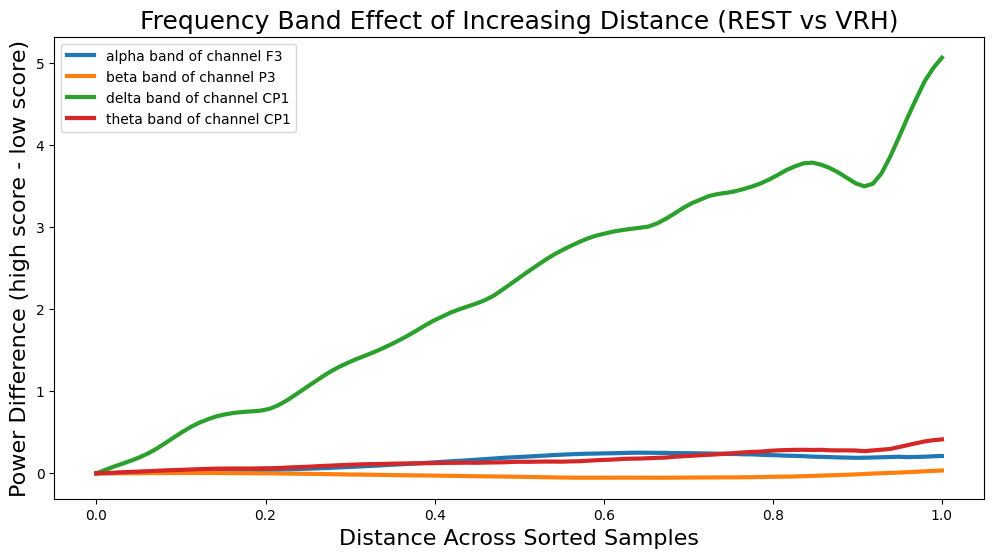

In [ ]:
# Analyze power evolution using absolute differences
window_size = 64  # Example window size
step_size = 4     # Example step size
band_power_over_time = analyze_power_evolution(t[:,chan_select], sorted_idx, window_size, step_size)

# Compute differences in power for each band
def compute_diffs(band_power_over_time, sorted_idx):
    bdiff = []
    target_chan = []
    distances = [torch.tensor(0)]
    band_idx = 0
    for band in frequency_bands:
        tmp_diff = torch.zeros(band_power_over_time[band].shape[1]).to(device)
        for dist in np.arange(1, int(.9 * band_power_over_time[band].shape[0])):
            if band_idx==0:
                distances.append(torch.tensor(dist))
            bpow0 = band_power_over_time[band][:-dist]
            bpow1 = band_power_over_time[band][dist:]
            mean_diff = (bpow1 - bpow0).mean(dim=0)
            tmp_diff = torch.vstack((tmp_diff, mean_diff))
        chan_idx = torch.argmax(tmp_diff.var(dim=0))
        target_chan.append(sliced_chan[chan_idx])
        bdiff.append(tmp_diff[:, chan_idx])
        band_idx += 1
    return torch.stack(distances), torch.stack(bdiff).T, target_chan

distances, bdiff, target_chan = compute_diffs(band_power_over_time, sorted_idx)

# Plot results
xax = distances/distances.max()
legend_list = [f"{band} band of channel {ch}" for band, ch in zip(frequency_bands.keys(), target_chan)]

plt.figure(figsize=(12, 6))
for i, band_diff in enumerate(bdiff.T):
    plt.plot(xax.cpu().numpy(), band_diff.cpu().numpy(), linewidth=3, label=legend_list[i])
plt.xlabel('Distance Across Sorted Samples', fontsize=16)
plt.ylabel('Power Difference (high score - low score)', fontsize=16)
plt.title('Frequency Band Effect of Increasing Distance (REST vs VRH)', fontsize=18)
plt.legend()
plt.show()

## Old Code

In [ ]:
# # Compute power differences
# cpow_pool, tpow = compute_power_diff(t, sorted_idx, device)

# Compute mean power and most variable channels for frequency bands
mean_power_and_channel = compute_mean_power_and_channel(t[sorted_idx, :17, :])
mean_band_pow = torch.stack([mean_power_and_channel[band]['mean_power'] for band in frequency_bands.keys()], dim=2).to(device)

# Compute power differences for each frequency band
bdiff = []
for i in range(len(frequency_bands)):
    tmp_diff = torch.zeros(17).to(device)
    for dist in np.arange(1, int(.51 * len(sorted_idx))):
        bpow0 = mean_band_pow[:-dist, :, i]
        bpow1 = mean_band_pow[dist:, :, i]
        mean_diff = (bpow1 - bpow0).mean(dim=0)
        tmp_diff = torch.vstack((tmp_diff, mean_diff))
    bdiff.append(tmp_diff[:, torch.argmax(tmp_diff.var(dim=0))])

# Plot results
xax = torch.linspace(0, 1, len(bdiff[0]))
sns.set(rc={'figure.figsize': (11.7, 8.27)})
legend_list = [f"{band} band" for band in frequency_bands.keys()]
for i, band_diff in enumerate(bdiff.T):
    plt.plot(xax.cpu().numpy(), band_diff.cpu().numpy(), linewidth=3, label=legend_list[i])
plt.xlabel('Distance Across Sorted Samples', fontsize=16)
plt.ylabel('Power Difference (high score - low score)', fontsize=16)
plt.title('Frequency Band Effect of Increasing Distance (REST vs VRH)', fontsize=18)
plt.legend([f"{band} band" for band in frequency_bands.keys()])
plt.show()

AttributeError: 'list' object has no attribute 'T'

In [ ]:
# Function to normalize EEG data
def normalize_eeg_data(x):
    eps = 1e-08
    mean = torch.nanmean(x, dim=2)
    std = torch.clamp_min(torch.std(x, dim=2), eps)
    x_norm = (x - mean.unsqueeze(-1)) / torch.clamp_min(std.unsqueeze(-1), eps)
    return torch.clamp(torch.clamp(x_norm, min=-3), max=3).float()

# Function to compute power differences
def compute_power_diff(t, sorted_idx, device, win_size=50*2):
    cpow = torch.square(t[sorted_idx])
    pool_test = nn.MaxPool2d(kernel_size=(1, win_size), stride=(1, win_size // 2), padding=(0, win_size // 2)).to('cpu')
    cpow_pool = pool_test(cpow.unsqueeze(1))[:, 0]
    
    eps = 1e-08
    t_max, t_min = cpow_pool.max(dim=2).values.max(dim=0).values, cpow_pool.min(dim=2).values.min(dim=0).values
    cpow_pool = (cpow_pool - t_min) / torch.clamp_min((t_max - t_min), eps)
    
    tpow = (torch.pow(t[sorted_idx], 2).mean(dim=2) - t_min) / torch.clamp_min((t_max - t_min), eps)
    
    return cpow_pool.to(device), tpow.to(device)

# Function to compute mean power and most variable channels for frequency bands
def compute_mean_power_and_channel(t, nfft=128):
    power_spectrum = torch.fft.fft(t.to('cpu'), n=nfft, dim=2).abs() ** 2
    mean_power_and_channel = {}

    for band_name, (low_freq, high_freq) in frequency_bands.items():
        freq_indices = torch.where((torch.fft.fftfreq(nfft, d=1 / 50) >= low_freq) &
                                   (torch.fft.fftfreq(nfft, d=1 / 50) <= high_freq))[0]
        band_power = power_spectrum[:, :, freq_indices].mean(dim=2)
        sorted_band_power, _ = band_power.sort(dim=0)
        percentile_25_idx = int(0.25 * sorted_band_power.shape[0])
        percentile_75_idx = int(0.75 * sorted_band_power.shape[0])
        percentile_diff = sorted_band_power[percentile_75_idx] - sorted_band_power[percentile_25_idx]
        max_var_channel_idx = torch.argmax(percentile_diff)
        mean_power_and_channel[band_name] = {'mean_power': band_power, 'max_var_channel_idx': max_var_channel_idx}

    return mean_power_and_channel